In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from particle import literals as lp  # --> MeV units

from Mu3e import fastmc as fm
from Mu3e import mudecays
from Mu3e import plot_tools as pt
from Mu3e import const
from Mu3e import models

import dill as pickle

### Standard Model decays

Import previously generated and processed events for Standard Model decays

In [6]:
# newtarget == surface target sampling
mu5e2nu = pickle.load(open("pickled_events/Dec_8_mu5e2nu_13M_newtarget.pkl", "rb"))

2023-12-09 16:35:15.048496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### New Physics Model

Create a DarkSector (DS) model object as a benchmark

In [8]:
baseline_model = models.DS(
    maprime=30, mphi=90, Femu=1.2e-14, alphaD=1 / 137, epsilon=1e-4
)

print(f"ctau h = {baseline_model.get_phi_ctau0()*1e12:.2g} fm")
print(f"tau h = {baseline_model.get_phi_tau0()*1e9:.2g} ns\n")
print(f"ctau aprime = {baseline_model.get_aprime_ctau0():.2g} mm")
print(f"tau aprime = {baseline_model.get_aprime_tau0()*1e9:.2g} ns\n")

print(f"B(µ --> e phi) = {baseline_model.get_mu5e_BR():.2g}")

ctau h = 2.9e+02 fm
tau h = 9.8e-13 ns

ctau aprime = 0.27 mm
tau aprime = 0.0009 ns

B(µ --> e phi) = 1e-12


### Generating events

Generate or import events for all muon decay types

In [9]:
NEVENTS = int(1e6)
GENERATE_EVENTS = False

In [10]:
if GENERATE_EVENTS:
    mu1e2nu = mudecays.Process(channel="mu1e2nu", n_events=NEVENTS)
    mu1e2nu.initialize_amplitude()
    mu1e2nu.generate()
    mu1e2nu.evaluate_amplitude()
    mu1e2nu.place_it_in_Mu3e()
    pickle.dump(mu1e2nu, open("pickled_events/mu1e2nu.pkl", "wb"))

In [11]:
if GENERATE_EVENTS:
    mu3e2nu = mudecays.Process(channel="mu3e2nu", n_events=NEVENTS)
    mu3e2nu.initialize_amplitude()
    mu3e2nu.generate()
    mu3e2nu.evaluate_amplitude()
    mu3e2nu.place_it_in_Mu3e()
    pickle.dump(mu3e2nu, open("pickled_events/mu3e2nu.pkl", "wb"))

In [12]:
if GENERATE_EVENTS:
    mu5e = mudecays.Process(channel="mu5e", model=baseline_model, n_events=NEVENTS)
    mu5e.initialize_amplitude()
    mu5e.generate()
    mu5e.evaluate_amplitude()
    mu5e.place_it_in_Mu3e()
    pickle.dump(mu5e, open("pickled_events/mu5e.pkl", "wb"))

In [13]:
if not GENERATE_EVENTS:
    mu1e2nu = pickle.load(open("pickled_events/Dec_8_mu1e2nu.pkl", "rb"))
    mu3e2nu = pickle.load(open("pickled_events/Dec_8_mu3e2nu.pkl", "rb"))
    mu5e = pickle.load(open("pickled_events/Dec_8_mu5e.pkl", "rb"))

### Efficiencies 

A first look into total efficiencies

In [15]:
def cut_full_reco(decay):
    mask = (decay.n_short_tracks == decay.n_tracks) & (Emiss[decay.channel] < 10)
    return const.get_pred_w_error(decay.weights, mask)


def cut_10MeV(decay):
    mask = Emiss[decay.channel] < 10
    return const.get_pred_w_error(decay.weights, mask)


def cut_10MeV_truth(decay, Ecut):
    Emiss_true = (
        decay.P_grid[:, :, decay.particle_names.index("nu_mu_bar")][:, 0]
        + decay.P_grid[:, :, decay.particle_names.index("nu_e")][:, 0]
    )
    mask = Emiss_true < Ecut
    return const.get_pred_w_error(decay.weights, mask)


def cut_Ee_gtr_truth(decay, Ecut):
    tracks_e = []
    tracks_e.append(decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 0])
    tracks_e.append(decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 0])
    tracks_e.append(decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 0])
    tracks_e.append(decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 0])
    tracks_e.append(decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 0])

    mask = np.ones_like(tracks_e[0], dtype=bool)
    for t in tracks_e:
        mask = mask & (t > Ecut)
    return const.get_pred_w_error(decay.weights, mask)


def cut_pT_gtr_truth(decay, Ecut):
    tracks_e = []
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 2] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 2] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 2] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 2] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 2] ** 2
        )
    )

    mask = np.ones_like(tracks_e[0], dtype=bool)
    for t in tracks_e:
        mask = mask & (t > Ecut)
    return const.get_pred_w_error(decay.weights, mask)


def cut_p_gtr_truth(decay, Ecut):
    tracks_e = []
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 2] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_0")][:, 3] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 2] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_1")][:, 3] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 2] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_1")][:, 3] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 2] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e+_2")][:, 3] ** 2
        )
    )
    tracks_e.append(
        np.sqrt(
            decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 1] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 2] ** 2
            + decay.P_grid[:, :, decay.particle_names.index("e-_2")][:, 3] ** 2
        )
    )

    mask = np.ones_like(tracks_e[0], dtype=bool)
    for t in tracks_e:
        mask = mask & (t > Ecut)
    return const.get_pred_w_error(decay.weights, mask)


def cut_short_tracks(decay):
    mask = decay.n_short_tracks == decay.n_tracks
    return const.get_pred_w_error(decay.weights, mask)


def cut_2ep_2em_tracks(decay):
    mask = (decay.n_short_tracks_minus == 2) & (decay.n_short_tracks == 4)
    return const.get_pred_w_error(decay.weights, mask)


def cut_1ep_2em_tracks(decay):
    mask = (decay.n_short_tracks_minus == 2) & (decay.n_short_tracks == 3)
    return const.get_pred_w_error(decay.weights, mask)


def cut_long_tracks(decay):
    mask = decay.n_long_tracks == decay.n_tracks
    return const.get_pred_w_error(decay.weights, mask)

In [29]:
print(f'B(mu+ > e+ e+e- e+e- vm~ ve | all Ee > 10 MeV) = {cut_Ee_gtr_truth(mu5e2nu, Ecut=10)}'.replace(","," ±"))
print(f'B(mu+ > e+ e+e- e+e- vm~ ve | all pT > 10 MeV) = {cut_pT_gtr_truth(mu5e2nu, Ecut=10)}'.replace(","," ±"))
print(f'B(mu+ > e+ e+e- e+e- vm~ ve | all p > 10 MeV) = {cut_p_gtr_truth(mu5e2nu, Ecut=10)}'.replace(","," ±"))

B(mu+ > e+ e+e- e+e- vm~ ve | all Ee > 10 MeV) = (9.871148874721362e-14 ± 1.962103350060051e-15)
B(mu+ > e+ e+e- e+e- vm~ ve | all pT > 10 MeV) = (1.4255339156880996e-14 ± 7.427021448886993e-16)
B(mu+ > e+ e+e- e+e- vm~ ve | all p > 10 MeV) = (9.712071177342232e-14 ± 1.946433034769091e-15)


## Kinematics 

In [31]:
tracks = {}
Etot = {}
Etot_vis = {}
Emiss = {}
Emiss_vis = {}
total_eminus_energy = {}
total_inv_mass = {}
low_ee_inv_mass = {}
for decay in [mu1e2nu, mu3e2nu, mu5e2nu, mu5e]:
    tracks[decay.channel] = decay.get_track_momenta()

    Etot[decay.channel] = np.zeros(decay.n_events)
    Etot_vis[decay.channel] = np.zeros(decay.n_events)
    total_eminus_energy[decay.channel] = np.zeros(decay.n_events)
    total_inv_mass[decay.channel] = np.zeros(decay.n_events)
    p_total = np.zeros((decay.n_events, 4))
    for name, track in tracks[decay.channel].items():
        # print(name)
        Etot[decay.channel] += track[:, 0]
        Etot_vis[decay.channel] += track[:, 0] * (decay.n_hits[name] >= 4)
        if "e-" in name:
            total_eminus_energy[decay.channel] += track[:, 0]

        p_total += track

    Emiss[decay.channel] = decay.p_parent[:, 0] - Etot[decay.channel]
    Emiss_vis[decay.channel] = decay.p_parent[:, 0] - Etot_vis[decay.channel]
    total_inv_mass[decay.channel] = np.sqrt(
        p_total[:, 0] ** 2
        - p_total[:, 1] ** 2
        - p_total[:, 2] ** 2
        - p_total[:, 3] ** 2
    )

In [32]:
parts = mu5e2nu.get_track_momenta()
mee_list = []
for eminus in ["e-_1", "e-_2"]:
    for eplus in ["e+_0", "e+_1", "e+_2"]:
        p = parts[eplus] + parts[eminus]
        mee_list.append(np.sqrt(p[:,0]**2 - np.sum(p[:,1:], axis=1)))

mee_lxist = np.array(mee_list)
lowmee_5e2nu = np.min(mee_list, axis=0)

# Short and long track multiplicity

/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:82: RuntimeWarning: invalid value encountered in divide
  eps = S / N
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)


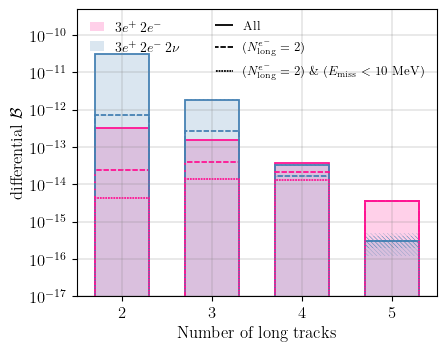

In [37]:
fig, ax = pt.std_fig()
BINS = np.linspace(0, 7, 8, endpoint=True)
WIDTH = 0.6
LW = 1.3


kwargs = {
    "lw": 0,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "alpha": 0.2,
    "linestyle": "-",
}
kwargs["facecolor"] = "deeppink"
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
kwargs["facecolor"] = "steelblue"
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)

kwargs["alpha"] = 1
kwargs["lw"] = LW
kwargs["facecolor"] = "None"
kwargs["label"] = None
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)

kwargs = {
    "lw": LW,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "facecolor": "None",
    "linestyle": (1, (3, 1)),
}
mask = (mu5e.n_hits["e-_1"] >= 6) & (mu5e.n_hits["e-_2"] >= 6)
# kwargs['label'] = r'$3e^+\, 2e^-$ ($N^{e^-}_{\rm long} = 2$)'
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask,
    **kwargs
)

# kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm long} = 2$)'
mask = (mu5e2nu.n_hits["e-_1"] >= 6) & (mu5e2nu.n_hits["e-_2"] >= 6)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask,
    rescale_w=1,
    **kwargs
)

kwargs = {
    "lw": LW,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "facecolor": "None",
    "linestyle": (1, (1, 0.5)),
}
mask_2 = (
    (mu5e.n_hits["e-_1"] >= 6) & (mu5e.n_hits["e-_2"] >= 6) & (Emiss_vis["mu5e"] < 10)
)
# kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm long} = 2$)'
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask_2,
    rescale_w=1,
    **kwargs
)

# kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm long} = 2$)'
mask_2 = (
    (mu5e2nu.n_hits["e-_1"] >= 6)
    & (mu5e2nu.n_hits["e-_2"] >= 6)
    & (Emiss_vis["mu5e2nu"] < 10)
)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask_2,
    rescale_w=1,
    **kwargs
)

ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(0.1e-16, 5e-10)
ax.set_yticks(np.geomspace(1e-17, 1e-10, 8, endpoint=True))

ax.set_xlabel(r"Number of long tracks", fontsize=12)
ax.set_xticks(BINS + 0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.0, 6)

ax.grid(alpha=1, lw=0.25, zorder=-10, color="grey")

leg1 = ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
    loc="upper left",
)
(l1,) = ax.plot([], [], lw=LW, ls=(1, (4, 0)), color="k")
(l2,) = ax.plot([], [], lw=LW, ls=(1, (3, 1)), color="k")
(l3,) = ax.plot([], [], lw=LW, ls=(1, (1, 0.5)), color="k")
leg2 = plt.legend(
    [l1, l2, l3],
    [
        r"All",
        r"$(N^{e^-}_{\rm long} = 2)$",
        r"$(N^{e^-}_{\rm long} = 2)$ \& ($E_{\rm miss} < 10$ MeV)",
    ],
    loc="upper right",
    frameon=False,
    fontsize=9,
    ncol=1,
    handlelength=1.5,
    columnspacing=2,
    markerfirst=True,
)
ax.add_artist(leg1)
fig.savefig("plots/long_track_multiplicity.pdf", dpi=400, bbox_inches="tight")

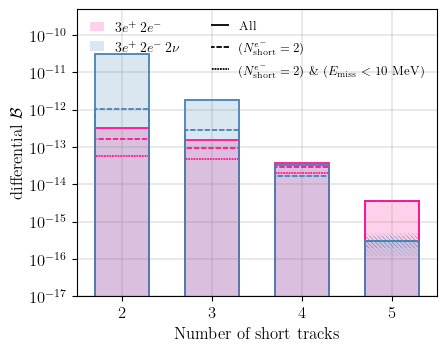

In [128]:
fig, ax = pt.std_fig()
BINS = np.linspace(0, 7, 8, endpoint=True)
WIDTH = 0.6
LW = 1.3

kwargs = {
    "lw": 0,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "alpha": 0.2,
    "linestyle": "-",
}
kwargs["facecolor"] = "deeppink"
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
kwargs["facecolor"] = "steelblue"
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)

kwargs = {
    "lw": LW,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "facecolor": "None",
    "linestyle": (1, (3, 1)),
}
mask = (mu5e.n_hits["e-_1"] >= 4) & (mu5e.n_hits["e-_2"] >= 4)
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask,
    **kwargs
)
mask = (mu5e2nu.n_hits["e-_1"] >= 4) & (mu5e2nu.n_hits["e-_2"] >= 4)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask,
    rescale_w=1,
    **kwargs
)

kwargs = {
    "lw": LW,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "facecolor": "None",
    "linestyle": (1, (1, 0.5)),
}
mask_2 = (
    (mu5e.n_hits["e-_1"] >= 4) & (mu5e.n_hits["e-_2"] >= 4) & (Emiss_vis["mu5e"] < 10)
)
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask_2,
    rescale_w=1,
    **kwargs
)
mask_2 = (
    (mu5e2nu.n_hits["e-_1"] >= 4)
    & (mu5e2nu.n_hits["e-_2"] >= 4)
    & (Emiss_vis["mu5e2nu"] < 10)
)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask_2,
    rescale_w=1,
    **kwargs
)


kwargs = {
    "lw": LW,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "alpha": 1,
    "linestyle": "-",
}
kwargs["facecolor"] = "None"
kwargs["label"] = None
_ = pt.get_histogram_and_errors(
    mu5e.n_long_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_long_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)


ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(0.1e-16, 5e-10)
ax.set_yticks(np.geomspace(1e-17, 1e-10, 8, endpoint=True))

ax.set_xlabel(r"Number of short tracks", fontsize=12)
ax.set_xticks(BINS + 0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.0, 6)

ax.grid(alpha=1, lw=0.25, zorder=-10, color="grey")

leg1 = ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
    loc="upper left",
)
(l1,) = ax.plot([], [], lw=LW, ls=(1, (4, 0)), color="k")
(l2,) = ax.plot([], [], lw=LW, ls=(1, (3, 1)), color="k")
(l3,) = ax.plot([], [], lw=LW, ls=(1, (1, 0.5)), color="k")
leg2 = plt.legend(
    [l1, l2, l3],
    [
        r"All",
        r"$(N^{e^-}_{\rm short} = 2)$",
        r"$(N^{e^-}_{\rm short} = 2)$ \& ($E_{\rm miss} < 10$ MeV)",
    ],
    loc="upper right",
    frameon=False,
    fontsize=9,
    ncol=1,
    handlelength=1.5,
    columnspacing=2,
    markerfirst=True,
)
ax.add_artist(leg1)
fig.savefig("plots/short_track_multiplicity.pdf", dpi=400, bbox_inches="tight")

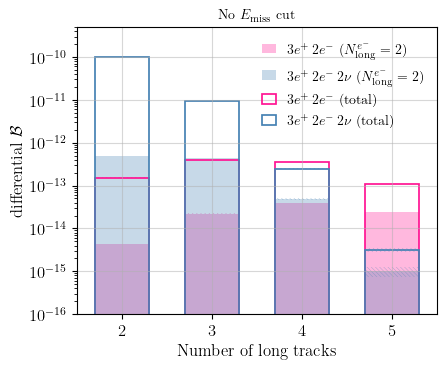

In [39]:
fig, ax = pt.std_fig()
BINS = np.linspace(0, 7, 8, endpoint=True)
WIDTH = 0.6
HITS = 6  # for long track

kwargs = {
    "lw": 0.0,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "alpha": 0.3,
    "facecolor": "deeppink",
}
mask = (mu5e.n_hits["e-_1"] >= HITS) & (mu5e.n_hits["e-_2"] >= HITS)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N^{e^-}_{\rm long} = 2$)"
_ = pt.get_histogram_and_errors(
    mu5e.n_short_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask,
    **kwargs
)

kwargs["facecolor"] = "steelblue"
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm long} = 2$)"
mask = (mu5e2nu.n_hits["e-_1"] >= HITS) & (mu5e2nu.n_hits["e-_2"] >= HITS)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_short_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask,
    rescale_w=1,
    **kwargs
)


kwargs = {"lw": 1.25, "histtype": "barstacked", "rwidth": WIDTH, "facecolor": "None"}
kwargs["label"] = r"$3e^+ \, 2e^-$ (total)"
_ = pt.get_histogram_and_errors(
    mu5e.n_short_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ (total)"
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_short_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)

ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 5e-10)
# ax.set_yticks(np.geomspace(1e-16, 1e-10, 6, endpoint=True))

ax.set_xlabel(r"Number of long tracks", fontsize=12)
ax.set_xticks(BINS + 0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.0, 6)

ax.grid(alpha=0.5, zorder=-1)
ax.set_title(r"No $E_{\rm miss}$ cut", fontsize=10)
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    loc="upper right",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/long_track_multiplicity_2electrons.pdf", dpi=400, bbox_inches="tight")

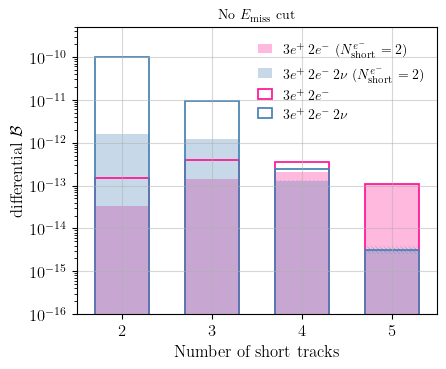

In [53]:
fig, ax = pt.std_fig()
BINS = np.linspace(0, 7, 8, endpoint=True)
WIDTH = 0.6

kwargs = {
    "lw": 0.0,
    "histtype": "barstacked",
    "rwidth": WIDTH,
    "alpha": 0.3,
    "facecolor": "deeppink",
}
mask = (mu5e.n_hits["e-_1"] >= 4) & (mu5e.n_hits["e-_2"] >= 4)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N^{e^-}_{\rm short} = 2$)"
_ = pt.get_histogram_and_errors(
    mu5e.n_short_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    mask=mask,
    **kwargs
)

kwargs["facecolor"] = "steelblue"
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm short} = 2$)"
mask = (mu5e2nu.n_hits["e-_1"] >= 4) & (mu5e2nu.n_hits["e-_2"] >= 4)
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_short_tracks,
    mu5e2nu,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    mask=mask,
    rescale_w=1,
    **kwargs
)


kwargs = {"lw": 1.25, "histtype": "barstacked", "rwidth": WIDTH, "facecolor": "None"}
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    mu5e.n_short_tracks,
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    errorbar=True,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    mu5e2nu.n_short_tracks,
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)

ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 5e-10)
# ax.set_yticks(np.geomspace(1e-16, 1e-10, 6, endpoint=True))

ax.set_xlabel(r"Number of short tracks", fontsize=12)
ax.set_xticks(BINS + 0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.0, 6)

ax.grid(alpha=0.5, zorder=-1)
ax.set_title(r"No $E_{\rm miss}$ cut", fontsize=10)
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    loc="upper right",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/short_track_multiplicity_2electrons.pdf", dpi=400, bbox_inches="tight")

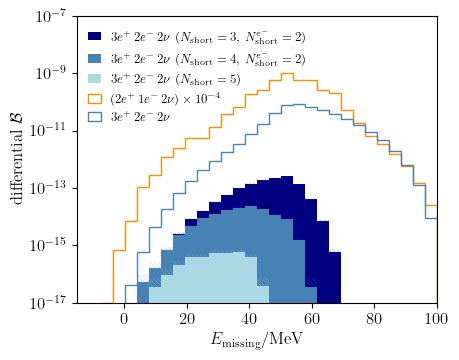

In [131]:
fig, ax = pt.std_fig()
BINS = np.linspace(-15, 100, 31, endpoint=True)
VAR = Emiss

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 1}
kwargs[
    "label"
] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$, $N^{e^-}_{\rm short} = 2$)"

kwargs["label"] = r"$2e^+ \, 1e^-\, 2\nu$ ($N_{\rm short} = 3$)"
obs_bhabha = (
    (mu3e2nu.particles_true["e+_0"][:, 0] > 20)
    | (mu3e2nu.particles_true["e+_1"][:, 0] > 20)
    | (mu3e2nu.particles_true["e-_1"][:, 0] > 20)
)
kwargs["facecolor"] = "orange"
mask3tracks = (mu3e2nu.n_short_tracks == 3) & obs_bhabha
# _ = pt.get_histogram_and_errors(
#     Emiss["mu3e2nu"],
#     mu3e2nu,
#     rescale_w=1e-4,
#     ax=ax,
#     bins=BINS,
#     color="orange",
#     errorbar=False,
#     mask=mask3tracks,
#     **kwargs
# )

kwargs["facecolor"] = "navy"
kwargs[
    "label"
] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 3$, $N^{e^-}_{\rm short} = 2$)"
mask3tracks = (mu5e2nu.n_short_tracks == 3) & (mu5e2nu.n_short_tracks_minus == 2)
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="navy",
    mask=mask3tracks,
    **kwargs
)

kwargs[
    "label"
] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 4$, $N^{e^-}_{\rm short} = 2$)"
mask4tracks = (mu5e2nu.n_short_tracks == 4) & (mu5e2nu.n_short_tracks_minus == 2)
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mask4tracks,
    **kwargs
)

kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)"
mask5tracks = (mu5e2nu.n_short_tracks == 5) & (mu5e2nu.n_short_tracks_minus == 2)
kwargs["facecolor"] = "lightblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="lightblue",
    mask=mask5tracks,
    **kwargs
)


kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$(2e^+ \, 1e^-\, 2\nu) \times 10^{-4}$"
_ = pt.get_histogram_and_errors(
    Emiss["mu3e2nu"],
    mu3e2nu,
    rescale_w=1e-4,
    ax=ax,
    bins=BINS,
    color="darkorange",
    errorbar=False,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=False,
    **kwargs
)

# kwargs = {'lw': 1, 'histtype': 'step'}
# kwargs['label'] = r'$3e^+ \, 2e^-$'
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=False, **kwargs)
# kwargs = {'lw': 0.0, 'histtype': 'stepfilled', 'alpha': 0.3}
# kwargs['label'] = r'$3e^+\, 2e^-$ ($N_{\rm short} = 5$)'
# kwargs['facecolor'] = 'deeppink'
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)

# kwargs = {'lw': 0.25, 'histtype': 'stepfilled', 'alpha': 1}
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'peachpuff', mask=mu5e.n_short_tracks == 5, **kwargs)
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 4, **kwargs)
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'indigo', mask=mu5e.n_short_tracks == 3, **kwargs)

ax.set_xlabel(r"$E_{\rm missing}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17, 1e-7)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=9,
    ncol=1,
    loc="upper left",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/mu5e2nu_missing_energy.pdf", dpi=400, bbox_inches="tight")

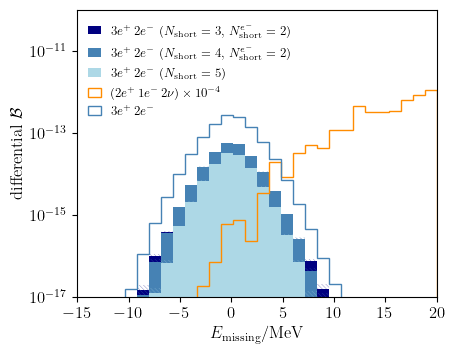

In [50]:
fig, ax = pt.std_fig()
BINS = np.linspace(-15, 20, 31, endpoint=True)
VAR = Emiss

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 1}
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$, $N^{e^-}_{\rm short} = 2$)"

# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$ ($N_{\rm short} = 3$)'
# obs_bhabha = (mu3e2nu.particles_true['e+_0'][:,0] > 20) | (mu3e2nu.particles_true['e+_1'][:,0] > 20) | (mu3e2nu.particles_true['e-_1'][:,0] > 20)
# kwargs['facecolor'] = 'orange'
# mask3tracks = (mu3e2nu.n_short_tracks == 3) & obs_bhabha
# _ = pt.get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, rescale_w=1e-4, ax=ax, bins = BINS, color = 'orange', errorbar=False, mask = mask3tracks, **kwargs)

kwargs["facecolor"] = "navy"
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 3$, $N^{e^-}_{\rm short} = 2$)"
mask3tracks = (mu5e.n_short_tracks == 3) & (mu5e.n_short_tracks_minus == 2)
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="navy",
    mask=mask3tracks,
    **kwargs
)

kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 4$, $N^{e^-}_{\rm short} = 2$)"
mask4tracks = (mu5e.n_short_tracks == 4) & (mu5e.n_short_tracks_minus == 2)
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mask4tracks,
    **kwargs
)

kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$)"
mask5tracks = (mu5e.n_short_tracks == 5) & (mu5e.n_short_tracks_minus == 2)
kwargs["facecolor"] = "lightblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="lightblue",
    mask=mask5tracks,
    **kwargs
)


kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$(2e^+ \, 1e^-\, 2\nu) \times 10^{-4}$"
_ = pt.get_histogram_and_errors(
    Emiss["mu3e2nu"],
    mu3e2nu,
    rescale_w=1e-4,
    ax=ax,
    bins=BINS,
    color="darkorange",
    errorbar=False,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=False,
    **kwargs
)

# kwargs = {'lw': 1, 'histtype': 'step'}
# kwargs['label'] = r'$3e^+ \, 2e^-$'
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=False, **kwargs)
# kwargs = {'lw': 0.0, 'histtype': 'stepfilled', 'alpha': 0.3}
# kwargs['label'] = r'$3e^+\, 2e^-$ ($N_{\rm short} = 5$)'
# kwargs['facecolor'] = 'deeppink'
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)

# kwargs = {'lw': 0.25, 'histtype': 'stepfilled', 'alpha': 1}
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'peachpuff', mask=mu5e.n_short_tracks == 5, **kwargs)
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 4, **kwargs)
# _ = pt.get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'indigo', mask=mu5e.n_short_tracks == 3, **kwargs)

ax.set_xlabel(r"$E_{\rm missing}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17, 1e-10)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=9,
    ncol=1,
    loc="upper left",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/mu5e2nu_missing_energy.pdf", dpi=400, bbox_inches="tight")

/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:82: RuntimeWarning: invalid value encountered in divide
  eps = S / N
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)


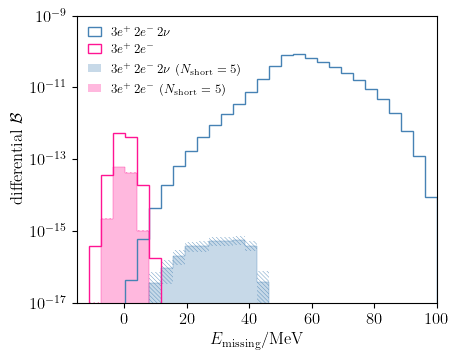

In [126]:
fig, ax = pt.std_fig()
BINS = np.linspace(-15, 100, 31, endpoint=True)
VAR = Emiss

kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=False,
    **kwargs
)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = pt.get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"], mu5e, ax=ax, bins=BINS, color="deeppink", errorbar=False, **kwargs
)

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "deeppink"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=mu5e.n_short_tracks == 5,
    **kwargs
)


kwargs = {"lw": 0.25, "histtype": "step", "alpha": 1}
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=mu5e.n_short_tracks == 5,
    **kwargs
)


ax.set_xlabel(r"$E_{\rm missing}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17, 1e-9)
# ax.set_ylim(0,0.5e-12)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=9,
    ncol=1,
    loc="upper left",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig(
    "plots/missing_energy_fullrange.pdf", dpi=400, bbox_inches="tight"
)

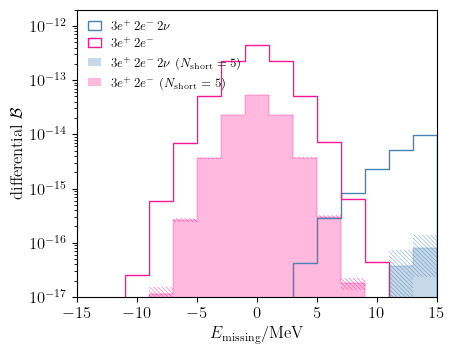

In [52]:
fig, ax = pt.std_fig()
BINS = np.linspace(-15, 15, 16, endpoint=True)
VAR = Emiss

kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=False,
    **kwargs
)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = pt.get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"], mu5e, ax=ax, bins=BINS, color="deeppink", errorbar=False, **kwargs
)

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "deeppink"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=mu5e.n_short_tracks == 5,
    **kwargs
)


kwargs = {"lw": 0.25, "histtype": "step", "alpha": 1}
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=mu5e.n_short_tracks == 5,
    **kwargs
)


ax.set_xlabel(r"$E_{\rm missing}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17, 2e-12)
# ax.set_ylim(0,0.5e-12)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=9,
    ncol=1,
    loc="upper left",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/missing_energy.pdf", dpi=400, bbox_inches="tight")

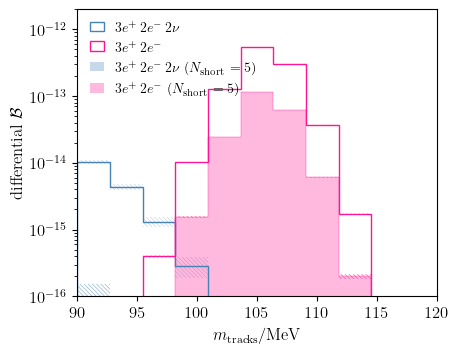

In [54]:
fig, ax = pt.std_fig()
delta = 0.15
BINS = np.linspace(90, 120, 12, endpoint=True)
VAR = total_inv_mass


kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = pt.get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"], mu5e, ax=ax, bins=BINS, color="deeppink", errorbar=True, **kwargs
)

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3}

kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$)"
kwargs["facecolor"] = "deeppink"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=(mu5e.n_short_tracks_minus == 2) & (mu5e.n_short_tracks == 4),
    **kwargs
)


kwargs = {"lw": 0.25, "histtype": "step", "alpha": 1}
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=mu5e2nu.n_short_tracks == 5,
    **kwargs
)
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=(mu5e.n_short_tracks_minus == 2) & (mu5e.n_short_tracks == 4),
    **kwargs
)


ax.set_xlabel(r"$m_{\rm tracks}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 2e-12)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    loc="upper left",
    handlelength=1,
    columnspacing=2,
    markerfirst=True,
)
fig.savefig("plots/inv_mass.pdf", dpi=400, bbox_inches="tight")

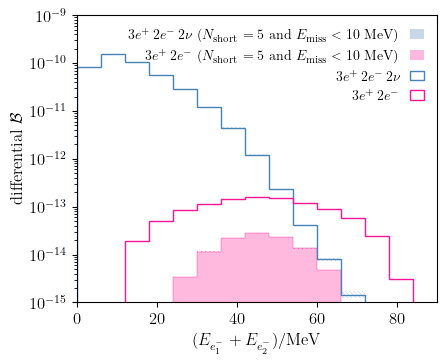

In [55]:
fig, ax = pt.std_fig()
delta = 0.15
BINS = np.linspace(0, 90, 16, endpoint=True)
VAR = total_eminus_energy

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3}
kwargs[
    "label"
] = r"$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$ and $E_{\rm miss} < 10$ MeV)"
kwargs["facecolor"] = "steelblue"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=((mu5e2nu.n_short_tracks == 5) & (Emiss["mu5e2nu"] <= 10)),
    **kwargs
)
kwargs["label"] = r"$3e^+\, 2e^-$ ($N_{\rm short} = 5$ and $E_{\rm miss} < 10$ MeV)"
kwargs["facecolor"] = "deeppink"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=((mu5e.n_short_tracks == 5) & (Emiss["mu5e"] < 10)),
    **kwargs
)


kwargs = {"lw": 0.25, "histtype": "step", "alpha": 1}
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    mask=((mu5e2nu.n_short_tracks == 5) & (Emiss["mu5e2nu"] <= 10)),
    **kwargs
)
_ = pt.get_histogram_and_errors(
    VAR["mu5e"],
    mu5e,
    ax=ax,
    bins=BINS,
    color="deeppink",
    mask=((mu5e.n_short_tracks == 5) & (Emiss["mu5e"] < 10)),
    **kwargs
)


kwargs = {"lw": 1, "histtype": "step"}
kwargs["label"] = r"$3e^+\, 2e^-\, 2\nu$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e2nu"],
    mu5e2nu,
    rescale_w=1,
    ax=ax,
    bins=BINS,
    color="steelblue",
    errorbar=True,
    **kwargs
)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = pt.get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs["label"] = r"$3e^+ \, 2e^-$"
_ = pt.get_histogram_and_errors(
    VAR["mu5e"], mu5e, ax=ax, bins=BINS, color="deeppink", errorbar=True, **kwargs
)

ax.set_xlabel(r"$(E_{e^-_1}+E_{e^-_2})$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-15, 1e-9)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=1,
    loc="upper right",
    handlelength=1,
    columnspacing=5,
    markerfirst=False,
)
fig.savefig("plots/electron_energy.pdf", dpi=400, bbox_inches="tight")

### Dark photon and dark scalar mass resolutions

In [59]:
def get_inv_mass(p):
    return np.sqrt(p[:,0]**2 - np.sum(p[:,1:]**2, axis=1))

def get_low_mee(decay):
    parts = decay.get_track_momenta()
    mee_list = []
    for eminus in ["e-_1", "e-_2"]:
        for eplus in ["e+_0", "e+_1", "e+_2"]:
            p = parts[eplus] + parts[eminus]
            mee_list.append(get_inv_mass(p))
    mee_list = np.array(mee_list)
    return np.min(mee_list, axis=0)


def get_dp_mee(decay):
    parts = decay.get_track_momenta()
    eminus = "e-_2"
    eplus = "e+_2"
    p = parts[eplus] + parts[eminus]
    return get_inv_mass(p)


def get_decay_from_model(my_model):
    mu5e = mudecays.Process(channel="mu5e", model=my_model, n_events=int(1e5))
    mu5e.initialize_amplitude()
    mu5e.generate()
    mu5e.evaluate_amplitude()
    mu5e.place_it_in_Mu3e()
    return mu5e


baseline_1 = models.DS(maprime=10, mphi=90, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4)
decay_mu5e_1 = get_decay_from_model(baseline_1)
dp_mee_1 = get_dp_mee(decay_mu5e_1)

baseline_2 = models.DS(maprime=20, mphi=90, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4)
decay_mu5e_2 = get_decay_from_model(baseline_2)
dp_mee_2 = get_dp_mee(decay_mu5e_2)

baseline_3 = models.DS(maprime=30, mphi=90, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4)
decay_mu5e_3 = get_decay_from_model(baseline_3)
dp_mee_3 = get_dp_mee(decay_mu5e_3)

baseline_4 = models.DS(maprime=40, mphi=90, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4)
decay_mu5e_4 = get_decay_from_model(baseline_4)
dp_mee_4 = get_dp_mee(decay_mu5e_4)

Oops! Violating perturbativity. Scalar quartic coupling, lambda =  3.7148759845368353


In [63]:
signal_mask_1 = (decay_mu5e_1.n_short_tracks == 5) & (decay_mu5e_1.Emiss < 10)
signal_mask_2 = (decay_mu5e_2.n_short_tracks == 5) & (decay_mu5e_2.Emiss < 10)
signal_mask_3 = (decay_mu5e_3.n_short_tracks == 5) & (decay_mu5e_3.Emiss < 10)
signal_mask_4 = (decay_mu5e_4.n_short_tracks == 5) & (decay_mu5e_4.Emiss < 10)

print(
    f'Reconstructed inv mass for {decay_mu5e_1.model.maprime}: {np.mean(dp_mee_1[signal_mask_1]):.2g} MeV, resolution: {np.std(dp_mee_1[signal_mask_1]) / np.mean(dp_mee_1[signal_mask_1]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_2.model.maprime}: {np.mean(dp_mee_2[signal_mask_2]):.2g} MeV, resolution: {np.std(dp_mee_2[signal_mask_2]) / np.mean(dp_mee_2[signal_mask_2]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_3.model.maprime}: {np.mean(dp_mee_3[signal_mask_3]):.2g} MeV, resolution: {np.std(dp_mee_3[signal_mask_3]) / np.mean(dp_mee_3[signal_mask_3]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_4.model.maprime}: {np.mean(dp_mee_4[signal_mask_4]):.2g} MeV, resolution: {np.std(dp_mee_4[signal_mask_4]) / np.mean(dp_mee_4[signal_mask_4]) *100:.2g}%'
)

Reconstructed inv mass for 10: 10 MeV, resolution: 2.4%
Reconstructed inv mass for 20: 20 MeV, resolution: 2.3%
Reconstructed inv mass for 30: 30 MeV, resolution: 2.3%
Reconstructed inv mass for 40: 40 MeV, resolution: 2.4%


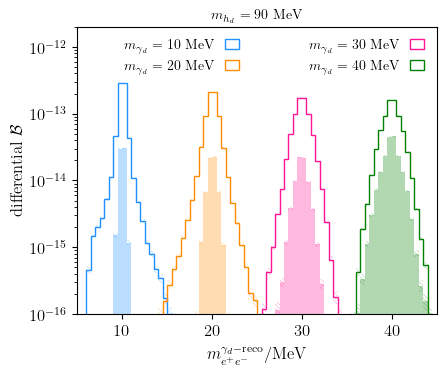

In [66]:
fig, ax = pt.std_fig()
BINS = np.linspace(5, 45, 81, endpoint=True)

from matplotlib.pyplot import cm

color = [
    "black",
    "dodgerblue",
    "darkorange",
    "deeppink",
    "green",
]  # cm.hsv(np.linspace(0, 1, 5))

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3, "density": False}
kwargs["facecolor"] = color[1]
_ = pt.get_histogram_and_errors(
    dp_mee_1,
    decay_mu5e_1,
    ax=ax,
    bins=BINS,
    color=color[1],
    mask=signal_mask_1,
    **kwargs,
)
kwargs["facecolor"] = color[2]
_ = pt.get_histogram_and_errors(
    dp_mee_2,
    decay_mu5e_2,
    ax=ax,
    bins=BINS,
    color=color[2],
    mask=signal_mask_2,
    **kwargs,
)
kwargs["facecolor"] = color[3]
_ = pt.get_histogram_and_errors(
    dp_mee_3,
    decay_mu5e_3,
    ax=ax,
    bins=BINS,
    color=color[3],
    mask=signal_mask_3,
    **kwargs,
)
kwargs["facecolor"] = color[4]
_ = pt.get_histogram_and_errors(
    dp_mee_4,
    decay_mu5e_4,
    ax=ax,
    bins=BINS,
    color=color[4],
    mask=signal_mask_4,
    **kwargs,
)


kwargs = {"lw": 1, "histtype": "step", "density": False}
kwargs["label"] = rf"$m_{{\gamma_d}} = {decay_mu5e_1.model.maprime:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dp_mee_1, decay_mu5e_1, ax=ax, bins=BINS, color=color[1], **kwargs
)
kwargs["label"] = rf"$m_{{\gamma_d}} = {decay_mu5e_2.model.maprime:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dp_mee_2, decay_mu5e_2, ax=ax, bins=BINS, color=color[2], **kwargs
)
kwargs["label"] = rf"$m_{{\gamma_d}} = {decay_mu5e_3.model.maprime:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dp_mee_3, decay_mu5e_3, ax=ax, bins=BINS, color=color[3], **kwargs
)
kwargs["label"] = rf"$m_{{\gamma_d}} = {decay_mu5e_4.model.maprime:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dp_mee_4, decay_mu5e_4, ax=ax, bins=BINS, color=color[4], **kwargs
)

ax.set_title(rf"$m_{{h_d}} = 90$~MeV", fontsize=10)

ax.set_xlabel(r"$m_{e^+e^-}^{{\gamma_d}-{\rm reco}}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 2e-12)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=2,
    loc="upper right",
    handlelength=1,
    columnspacing=5,
    markerfirst=False,
)
fig.savefig("plots/dp_mee.pdf", dpi=400, bbox_inches="tight")

In [67]:
def get_dh_mee(decay):
    parts = decay.get_track_momenta()
    p = parts["e+_1"] + parts["e-_1"] + parts["e+_2"] + parts["e-_2"]
    return get_inv_mass(p)


baseline_1 = models.DS(
    maprime=45 / 3, mphi=45, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4
)
decay_mu5e_1 = get_decay_from_model(baseline_1)
dh_mee_1 = get_dh_mee(decay_mu5e_1)

baseline_2 = models.DS(
    maprime=60 / 3, mphi=60, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4
)
decay_mu5e_2 = get_decay_from_model(baseline_2)
dh_mee_2 = get_dh_mee(decay_mu5e_2)

baseline_3 = models.DS(
    maprime=75 / 3, mphi=75, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4
)
decay_mu5e_3 = get_decay_from_model(baseline_3)
dh_mee_3 = get_dh_mee(decay_mu5e_3)

baseline_4 = models.DS(
    maprime=90 / 3, mphi=90, Femu=1e-14, alphaD=1 / 137, epsilon=1e-4
)
decay_mu5e_4 = get_decay_from_model(baseline_4)
dh_mee_4 = get_dh_mee(decay_mu5e_4)

In [68]:
signal_mask_1 = (decay_mu5e_1.n_short_tracks == 5) & (decay_mu5e_1.Emiss < 10)
signal_mask_2 = (decay_mu5e_2.n_short_tracks == 5) & (decay_mu5e_2.Emiss < 10)
signal_mask_3 = (decay_mu5e_3.n_short_tracks == 5) & (decay_mu5e_3.Emiss < 10)
signal_mask_4 = (decay_mu5e_4.n_short_tracks == 5) & (decay_mu5e_4.Emiss < 10)


print(
    f'Reconstructed inv mass for {decay_mu5e_1.model.mphi}: {np.mean(dh_mee_1[signal_mask_1]):.2g} MeV, resolution: {np.std(dh_mee_1[signal_mask_1]) / np.mean(dh_mee_1[signal_mask_1]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_2.model.mphi}: {np.mean(dh_mee_2[signal_mask_2]):.2g} MeV, resolution: {np.std(dh_mee_2[signal_mask_2]) / np.mean(dh_mee_2[signal_mask_2]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_3.model.mphi}: {np.mean(dh_mee_3[signal_mask_3]):.2g} MeV, resolution: {np.std(dh_mee_3[signal_mask_3]) / np.mean(dh_mee_3[signal_mask_3]) *100:.2g}%'
)
print(
    f'Reconstructed inv mass for {decay_mu5e_4.model.mphi}: {np.mean(dh_mee_4[signal_mask_4]):.2g} MeV, resolution: {np.std(dh_mee_4[signal_mask_4]) / np.mean(dh_mee_4[signal_mask_4]) *100:.2g}%'
)

Reconstructed inv mass for 45: 45 MeV, resolution: 1.5%
Reconstructed inv mass for 60: 60 MeV, resolution: 1.6%
Reconstructed inv mass for 75: 75 MeV, resolution: 1.7%
Reconstructed inv mass for 90: 90 MeV, resolution: 1.7%
0.015276472026762569 0.9999277045012421
0.016025006318127564 0.9994048941163989
0.016541762733358865 1.0001504157562082
0.017435343287478595 1.0000473901598768


/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:82: RuntimeWarning: invalid value encountered in divide
  eps = S / N
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:83: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)


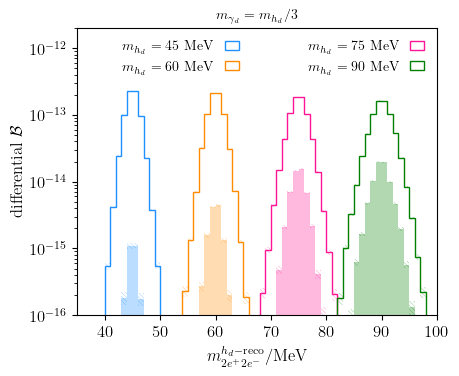

In [69]:
fig, ax = pt.std_fig()
BINS = np.linspace(35, 100, (100 - 35) + 1, endpoint=True)

from matplotlib.pyplot import cm

color = [
    "black",
    "dodgerblue",
    "darkorange",
    "deeppink",
    "green",
]  # cm.hsv(np.linspace(0, 1, 5))

kwargs = {"lw": 0.0, "histtype": "stepfilled", "alpha": 0.3, "density": False}
kwargs["facecolor"] = color[1]
_ = pt.get_histogram_and_errors(
    dh_mee_1,
    decay_mu5e_1,
    ax=ax,
    bins=BINS,
    color=color[1],
    mask=((decay_mu5e_1.n_short_tracks == 5) & (decay_mu5e_1.Emiss < 10)),
    **kwargs,
)
kwargs["facecolor"] = color[2]
_ = pt.get_histogram_and_errors(
    dh_mee_2,
    decay_mu5e_2,
    ax=ax,
    bins=BINS,
    color=color[2],
    mask=((decay_mu5e_2.n_short_tracks == 5) & (decay_mu5e_2.Emiss < 10)),
    **kwargs,
)
kwargs["facecolor"] = color[3]
_ = pt.get_histogram_and_errors(
    dh_mee_3,
    decay_mu5e_3,
    ax=ax,
    bins=BINS,
    color=color[3],
    mask=((decay_mu5e_3.n_short_tracks == 5) & (decay_mu5e_3.Emiss < 10)),
    **kwargs,
)
kwargs["facecolor"] = color[4]
_ = pt.get_histogram_and_errors(
    dh_mee_4,
    decay_mu5e_4,
    ax=ax,
    bins=BINS,
    color=color[4],
    mask=((decay_mu5e_4.n_short_tracks == 5) & (decay_mu5e_4.Emiss < 10)),
    **kwargs,
)


kwargs = {"lw": 1, "histtype": "step", "density": False}
kwargs["label"] = rf"$m_{{h_d}} = {decay_mu5e_1.model.mphi:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dh_mee_1, decay_mu5e_1, ax=ax, bins=BINS, color=color[1], **kwargs
)
kwargs["label"] = rf"$m_{{h_d}} = {decay_mu5e_2.model.mphi:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dh_mee_2, decay_mu5e_2, ax=ax, bins=BINS, color=color[2], **kwargs
)
kwargs["label"] = rf"$m_{{h_d}} = {decay_mu5e_3.model.mphi:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dh_mee_3, decay_mu5e_3, ax=ax, bins=BINS, color=color[3], **kwargs
)
kwargs["label"] = rf"$m_{{h_d}} = {decay_mu5e_4.model.mphi:.0f}$~MeV"
_ = pt.get_histogram_and_errors(
    dh_mee_4, decay_mu5e_4, ax=ax, bins=BINS, color=color[4], **kwargs
)

ax.set_title(rf"$m_{{\gamma_d}} = m_{{h_d}}/3$", fontsize=10)

ax.set_xlabel(r"$m_{2e^+2e^-}^{{h_d}-{\rm reco}}$/MeV", fontsize=12)
ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 2e-12)
ax.set_xlim(BINS.min(), BINS.max())
ax.legend(
    frameon=False,
    fontsize=10,
    ncol=2,
    loc="upper right",
    handlelength=1,
    columnspacing=5,
    markerfirst=False,
)
fig.savefig("plots/dh_m4e.pdf", dpi=400, bbox_inches="tight")

## Generate many new physics cases

In [60]:
def get_events(model, nevents=1000):
    decay = mudecays.Process(channel="mu5e", model=model, n_events=nevents)
    decay.initialize_amplitude()
    decay.generate()
    decay.evaluate_amplitude()
    decay.place_it_in_Mu3e()
    return decay


def get_Femu(decay, BR_limit=1e-12, apply_eff=True):
    if apply_eff:
        Etot = np.zeros(decay.n_events)
        tracks = decay.get_track_momenta()
        for _, track in tracks.items():
            Etot += track[:, 0]
        Emiss = decay.p_parent[:, 0] - Etot
        eff = (
            decay.weights[(decay.n_short_tracks == decay.n_tracks) & (Emiss < 10)].sum()
            / decay.weights.sum()
        )

        return np.sqrt(
            BR_limit / (eff * decay.model.get_mu5e_BR() / decay.model.Femu**2)
        )
    else:
        return np.sqrt(BR_limit / (decay.model.get_mu5e_BR() / decay.model.Femu**2))


def get_eff(decay):
    Etot = np.zeros(decay.n_events)
    tracks = decay.get_track_momenta()
    for _, track in tracks.items():
        Etot += track[:, 0]
    Emiss = decay.p_parent[:, 0] - Etot
    eff = (
        decay.weights[(decay.n_short_tracks == decay.n_tracks) & (Emiss < 10)].sum()
        / decay.weights.sum()
    )
    return eff

In [62]:
from Mu3e.mudecays import Gamma_mu
from Mu3e import models
import DarkNews as dn

In [64]:
mphis = np.array([15, 30, 45, 60, 75, 90])
map_dic = {mphi: np.linspace(2, mphi / 2.05, 30, endpoint=True) for mphi in mphis}
model_dic = {
    mphi: [
        models.DS(maprime=maprime, mphi=mphi, Femu=1e-6, epsilon=1e-4, alphaD=1 / 137)
        for maprime in map_dic[mphi]
    ]
    for mphi in mphis
}
events_dic = {
    mphi: [get_events(model, nevents=int(5e5)) for model in model_dic[mphi]]
    for mphi in mphis
}
eff_dic = {mphi: [get_eff(decay) for decay in events_dic[mphi]] for mphi in mphis}
Femu_1e12_dic = {
    mphi: [get_Femu(decay, BR_limit=1e-12) for decay in events_dic[mphi]]
    for mphi in mphis
}
respects_unitarity = {
    mphi: [model.lambda_quartic < np.sqrt(4 * np.pi) for model in model_dic[mphi]]
    for mphi in mphis
}

Oops! Violating perturbativity. Scalar quartic coupling, lambda =  10.319099957046763
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  6.957743348787484
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  5.006549176150209
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  3.774318115588636
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  23.217974903355223
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  12.853887563751567
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  8.14879329877721
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  5.623337980369939
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  4.112928335606076
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  41.27639982818705
Oops! Violating perturbativity. Scalar quartic coupling, lambda =  19.09777020141503
Oops! Violating perturbativity. Scalar quartic coupling, lambda

In [65]:
Femu_2e3_dic = {
    mphi: [
        get_Femu(decay, BR_limit=2e-3, apply_eff=False) for decay in events_dic[mphi]
    ]
    for mphi in mphis
}
Femu_4e6_dic = {
    mphi: [
        get_Femu(decay, BR_limit=4e-6, apply_eff=False) for decay in events_dic[mphi]
    ]
    for mphi in mphis
}

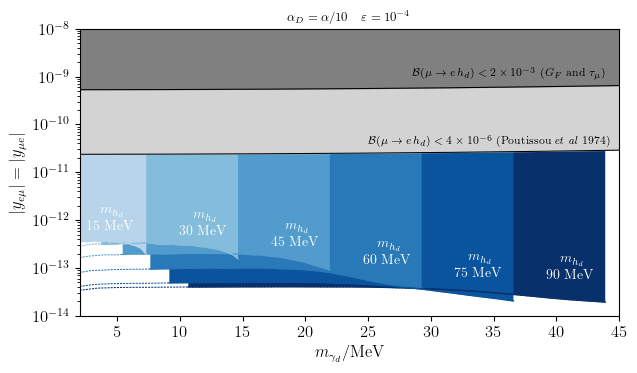

In [66]:
fig, ax = pt.std_fig(figsize=(1.5 * 1.2 * 3.7, 1.6 * 2.3617))
from matplotlib.pyplot import cm

color = cm.Blues(np.linspace(0.3, 1, len(mphis)))
color2 = cm.Blues(np.linspace(0.3, 1, len(mphis)))
for mphi, c, creverse in zip(mphis[::-1], color[::-1], color2):
    mask = respects_unitarity[mphi]
    x = np.array(map_dic[mphi])
    y = np.array(Femu_1e12_dic[mphi])
    ax.plot(x[mask], y[mask], lw=1.0, label=rf"$m_\varphi = {mphi:.0f}$ MeV", color=c)
    ax.plot(
        x,
        y,
        lw=0.75,
        label=rf"$m_\varphi = {mphi:.0f}$ MeV",
        color=c,
        linestyle=(0, (2, 1)),
    )
    # ax.fill_between(x, y, np.ones(len(x)), lw=0, ec='None', facecolor=c, alpha=1)
    ax.fill_between(
        x[mask], y[mask], np.ones(len(x[mask])), lw=0, ec="None", facecolor=c, alpha=1
    )

    # ax.fill_between(x[mask], y_u[mask], np.ones(len(x[mask])), lw=0, ec='None', facecolor='dimgrey', alpha=1)

    ax.annotate(
        rf"\noindent\quad$m_{{h_d}}$\\${mphi:.0f}$ MeV",
        xy=(map_dic[mphi][-1] - 4.7, Femu_1e12_dic[mphi][-1] * 7),
        xycoords="data",
        rotation=0,
        fontsize=10,
        c="white",
    )


x = np.linspace(2, 45, 1000)
rphi = x / lp.mu_minus.mass
rl = lp.e_minus.mass / lp.mu_minus.mass
Br_muephi = (
    lp.mu_minus.mass
    / 16
    / np.pi
    * dn.const.kallen_sqrt(1, rl**2, rphi**2)
    * ((1 + rl) ** 2 - rphi**2)
    / Gamma_mu
)


yemu_limit = np.sqrt(4e-6 / Br_muephi)
# Femu_limit_Hdecays = 8.9e-11/np.sqrt(1/137*4*np.pi/10)*(x/20)
plt.fill_between(x, yemu_limit, np.ones(len(x)), color="lightgrey", alpha=1)
plt.plot(x, yemu_limit, color="black", lw=0.75)

yemu_limit = np.sqrt(2e-3 / Br_muephi)
# Femu_limit_Hdecays = 8.9e-11/np.sqrt(1/137*4*np.pi/10)*(x/20)
plt.fill_between(x, yemu_limit, np.ones(len(x)), color="grey")
plt.plot(x, yemu_limit, color="black", lw=0.75)


ax.set_xlabel(r"$m_{\gamma_d}$/MeV", fontsize=12)
ax.set_ylabel(r"$|y_{e\mu}| = |y_{\mu e}|$", fontsize=12)
# ax.legend(frameon=False, fontsize=10, ncol=1, loc='center right', handlelength=1, columnspacing=2, markerfirst=True)
ax.annotate(
    r"$\mathcal{B}(\mu \to e \, h_d) < 2 \times 10^{-3}$ {\footnotesize ($G_F$ and $\tau_\mu$)}",
    xy=(28.5, 1e-9),
    fontsize=8,
    color="black",
)
ax.annotate(
    r"\noindent $\mathcal{B}(\mu \to e \, h_d) < 4 \times 10^{-6}$ {\footnotesize (Poutissou \emph{et al} 1974)}",
    xy=(25, 4e-11),
    fontsize=8,
    color="black",
)
# ax.annotate(r'$\mathcal{B}(\mu^+ \to e^+ \varphi)<10^{-12}$ @ Mu3e', xy=(0.04, 0.02), xycoords='axes fraction', fontsize=10, color=color[-1])
ax.set_title(r"$\alpha_D = \alpha/10 \quad \varepsilon = 10^{-4}$", fontsize=9)

ax.set_xlim(2, 45)
ax.set_ylim(1e-14, 1e-8)
ax.set_yscale("log")
fig.savefig("plots/sensitivity_DS_newtarget.pdf", dpi=400, bbox_inches="tight")

In [1047]:
x = np.array(list(map_dic.keys())).T
Y = np.array(list(map_dic.values()))
X, _ = np.meshgrid(x, y[0])
X = X.T
Z = np.array(list(eff_dic.values()))

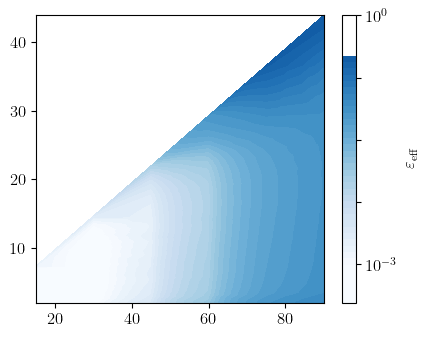

In [1108]:
from matplotlib.colors import LogNorm

fig, ax = pt.std_fig()
# _ = plt.hist2d(X.flatten(), Y.flatten(), weights=Z.flatten(), bins=100, norm=LogNorm(vmax=1,vmin=1e-4), cmap='Blues')

cs = plt.tricontourf(
    X.flatten(),
    Y.flatten(),
    Z.flatten(),
    levels=np.geomspace(Z.min(), Z.max(), 40),
    cmap="Blues",
    norm=LogNorm(vmin=1e-3, vmax=1),
    vmin=1e-3,
    vmax=1,
)
ax_c = fig.colorbar(cs, label=r"$\varepsilon_{\mathrm{eff}}$").ax
ax_c.set_yticks(np.geomspace(1e-3, 1, 5))

## Some details of the simulation

In [70]:
# Save to file
x, y = np.genfromtxt("Mu3e/exp_params/decays_in_z_position.dat", unpack=True)
zcoeffs = np.polyfit(x, y, 10)
zpos_fit = np.poly1d(zcoeffs)
np.save("Mu3e/exp_params/zpos_fit_pdf.npy", zpos_fit)

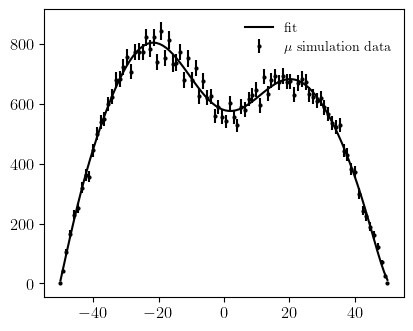

In [71]:
# data generation
fig, ax = pt.std_fig()
ax.errorbar(
    x,
    y,
    yerr=np.sqrt(y),
    linestyle="None",
    marker="o",
    color="k",
    markersize=2,
    label=r"$\mu$ simulation data",
)
z = np.linspace(-50, 50, 100)
ax.plot(z, zpos_fit(z), color="k", label="fit")
ax.legend()

In [ ]:
# nsamples = int(1e6)
# P = np.random.uniform(0,53, nsamples)
# P = dn.Cfourvec.random_normal(P, 0.2*P/P)
# phi = np.random.uniform(0,2*np.pi, nsamples)
# cphi = np.cos(phi)
# sphi = np.sin(phi)
# ctheta = np.random.uniform(-1,1, nsamples)
# stheta = np.sqrt(1 - ctheta**2)
# angle_lambda = np.pi/2 - np.arccos(ctheta)

# p = np.array([np.sqrt(P**2 + lp.e_minus.mass**2), P*stheta*cphi, P*stheta*sphi, P*ctheta]).T

In [111]:
mu1e2nu

python(98574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


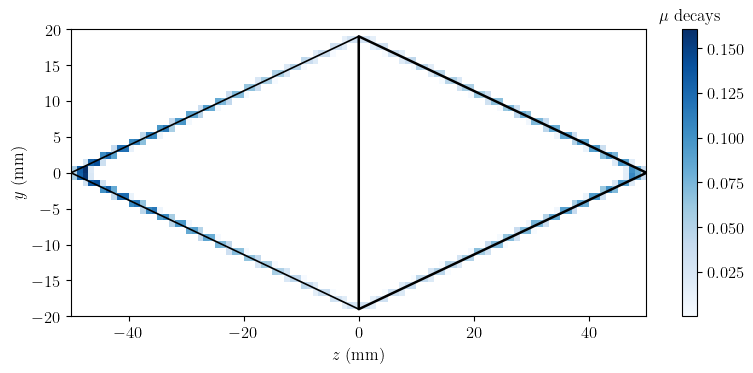

In [78]:
scale_factor = 10 / 5
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0] * scale_factor, pt.std_figsize[1]))
mask = (-1 <  mu5e.x) & (mu5e.x < 1)
h = ax.hist2d(
    mu5e.z[mask],
    mu5e.y[mask],
    weights=mu5e.weights[mask] / np.max(mu5e.weights[mask]) / 100 / 40,
    bins=(100, 40),
    cmap="Blues",
    cmin=1e-100,
    density=False,
)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

ax.plot([-50, 0, 0, -50], [0, 19, -19, 0], color="black", lw=1.2)
ax.plot([50, 0, 0, 50], [0, 19, -19, 0], color="black", lw=1.8)

ax.set_ylim(-20, 20)
ax.set_xlim(-50, 50)
ax.set_xlabel(r"$z$ (mm)")
ax.set_ylabel(r"$y$ (mm)")

fig.savefig("plots/target_z_y.png", dpi=400, bbox_inches="tight")

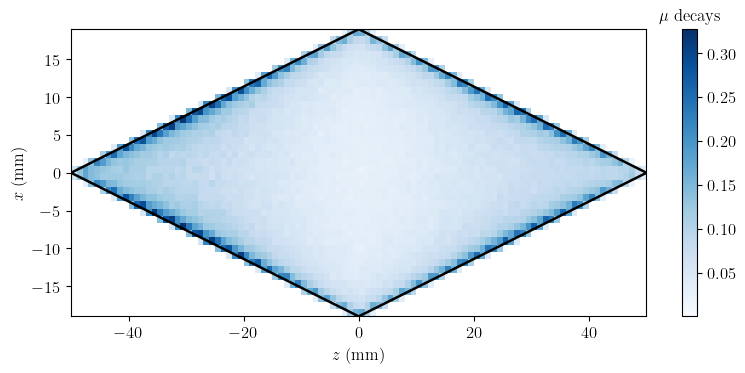

In [83]:
scale_factor = 10 / 5
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0] * scale_factor, pt.std_figsize[1]))

h = ax.hist2d(
    mu5e.z,
    mu5e.y,
    weights=mu5e.weights / np.max(mu5e.weights) / 100 / 40,
    bins=(100, 40),
    cmap="Blues",
    cmin=1e-100,
    density=False,
)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

ax.plot([-50, 0, 50, 0, -50], [0, 19, 0, -19, 0], color="black", lw=1.8)

# ax.set_ylim(-20,20)
# ax.set_xlim(-50,50)
ax.set_xlabel(r"$z$ (mm)")
ax.set_ylabel(r"$x$ (mm)")

fig.savefig("plots/target_z_x.png", dpi=400, bbox_inches="tight")

python(98541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


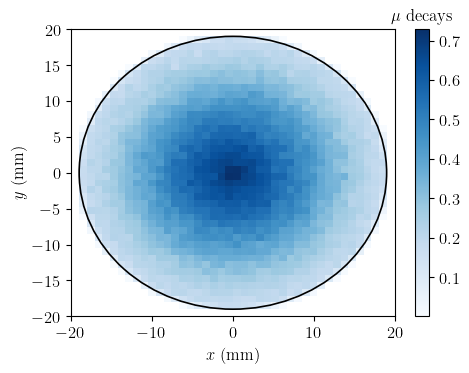

In [74]:
scale_factor = 4.5 / 4
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0] * scale_factor, pt.std_figsize[1]))

h = ax.hist2d(
    mu5e.x,
    mu5e.y,
    weights=mu5e.weights / np.max(mu5e.weights) / 40 / 40,
    bins=(40, 40),
    cmap="Blues",
    cmin=1e-100,
    density=False,
)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

circle = plt.Circle((0, 0), 19, fill=False, color="black", lw=1.2)
ax.add_patch(circle)

ax.set_ylim(-20, 20)
ax.set_xlim(-20, 20)
ax.set_xlabel(r"$x$ (mm)")
ax.set_ylabel(r"$y$ (mm)")

fig.savefig("plots/target_x_y.png", dpi=400, bbox_inches="tight")

In [122]:
p = mu1e2nu.particles_true['e+_0']
pmag = np.sqrt(p[:, 1] ** 2 + p[:, 2] ** 2 + p[:, 3] ** 2)
# pT = np.sqrt(p[:, 1] ** 2 + p[:, 2] ** 2)
pL = p[:, 3]

# Angle wrt the z axis
angle_lambda = np.pi / 2 - np.arccos(pL / pmag)

nhits = mu1e2nu.n_hits['e+_0']

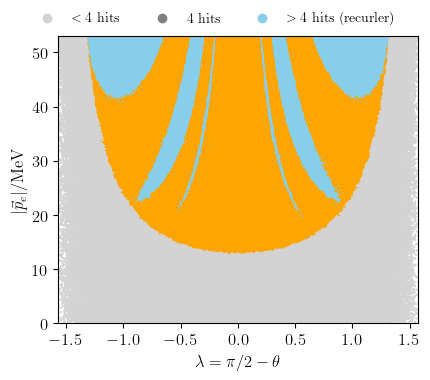

In [125]:
fig, ax = pt.std_fig()
size = 3

h = ax.scatter(
    angle_lambda[nhits < 4],
    pmag[nhits < 4],
    s=size,
    color="lightgrey",
    zorder=2,
    edgecolor="None",
)

h = ax.scatter(
    angle_lambda[nhits >= 4], pmag[nhits >= 4], s=size, color="skyblue", zorder=0, edgecolor="None"
)
h = ax.scatter(
    angle_lambda[nhits >= 6],
    pmag[nhits >= 6],
    s=size,
    color="orange",
    zorder=1,
    edgecolor="None",
)

h = ax.scatter([], [], color="lightgrey", label=r"$< 4$ hits")
h = ax.scatter([], [], color="grey", label=r"$4$ hits")
h = ax.scatter([], [], color="skyblue", label=r"$> 4$ hits (recurler)")


# h = ax.hist2d(angle_lambda, P, bins=500, weights=cuts, cmap='bone_r', norm=plt.Normalize(vmin=0, vmax=1), zorder=0, alpha=0.5)

ax.set_xlabel(r"$\lambda = \pi/2-\theta$")
ax.set_ylabel(r"$|\vec{p}_e|$/MeV")
ax.set_xlim(-np.pi / 2, np.pi / 2)
ax.set_ylim(0, 53)
fig.legend(loc="upper center", ncol=3, fontsize=10)

fig.savefig("plots/mu5e_recurler_hits.png", dpi=400, bbox_inches="tight")